# Import des librairies

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Chargement des données

In [2]:
# Ajouter le chemin du projet au PATH
sys.path.append(os.path.abspath(".."))
from modules.data_import import loadAndMergeData, exportDataCSV, loadInTime, loadOutTime

# Charger les données
generalData = loadAndMergeData()
inTime = loadInTime()
outTime = loadOutTime()

# Visualisation des données

In [3]:
generalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

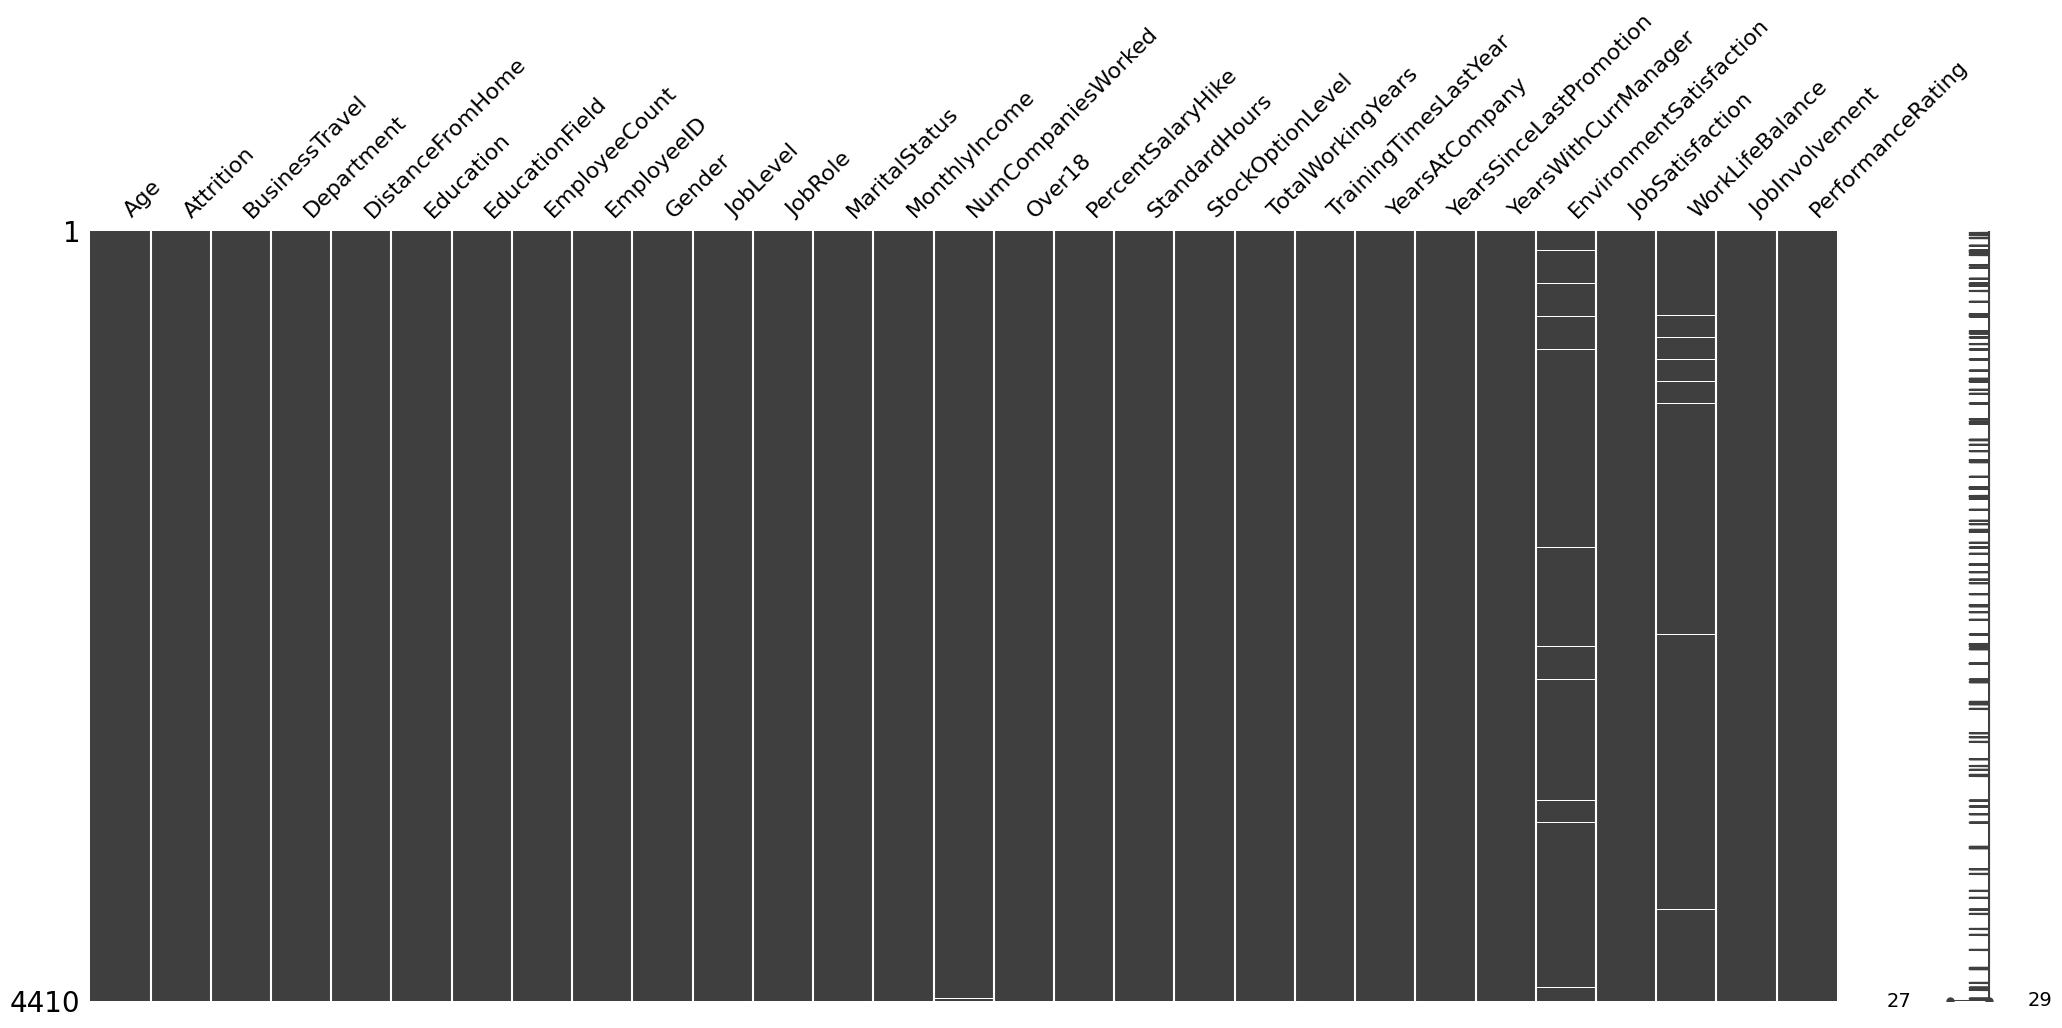

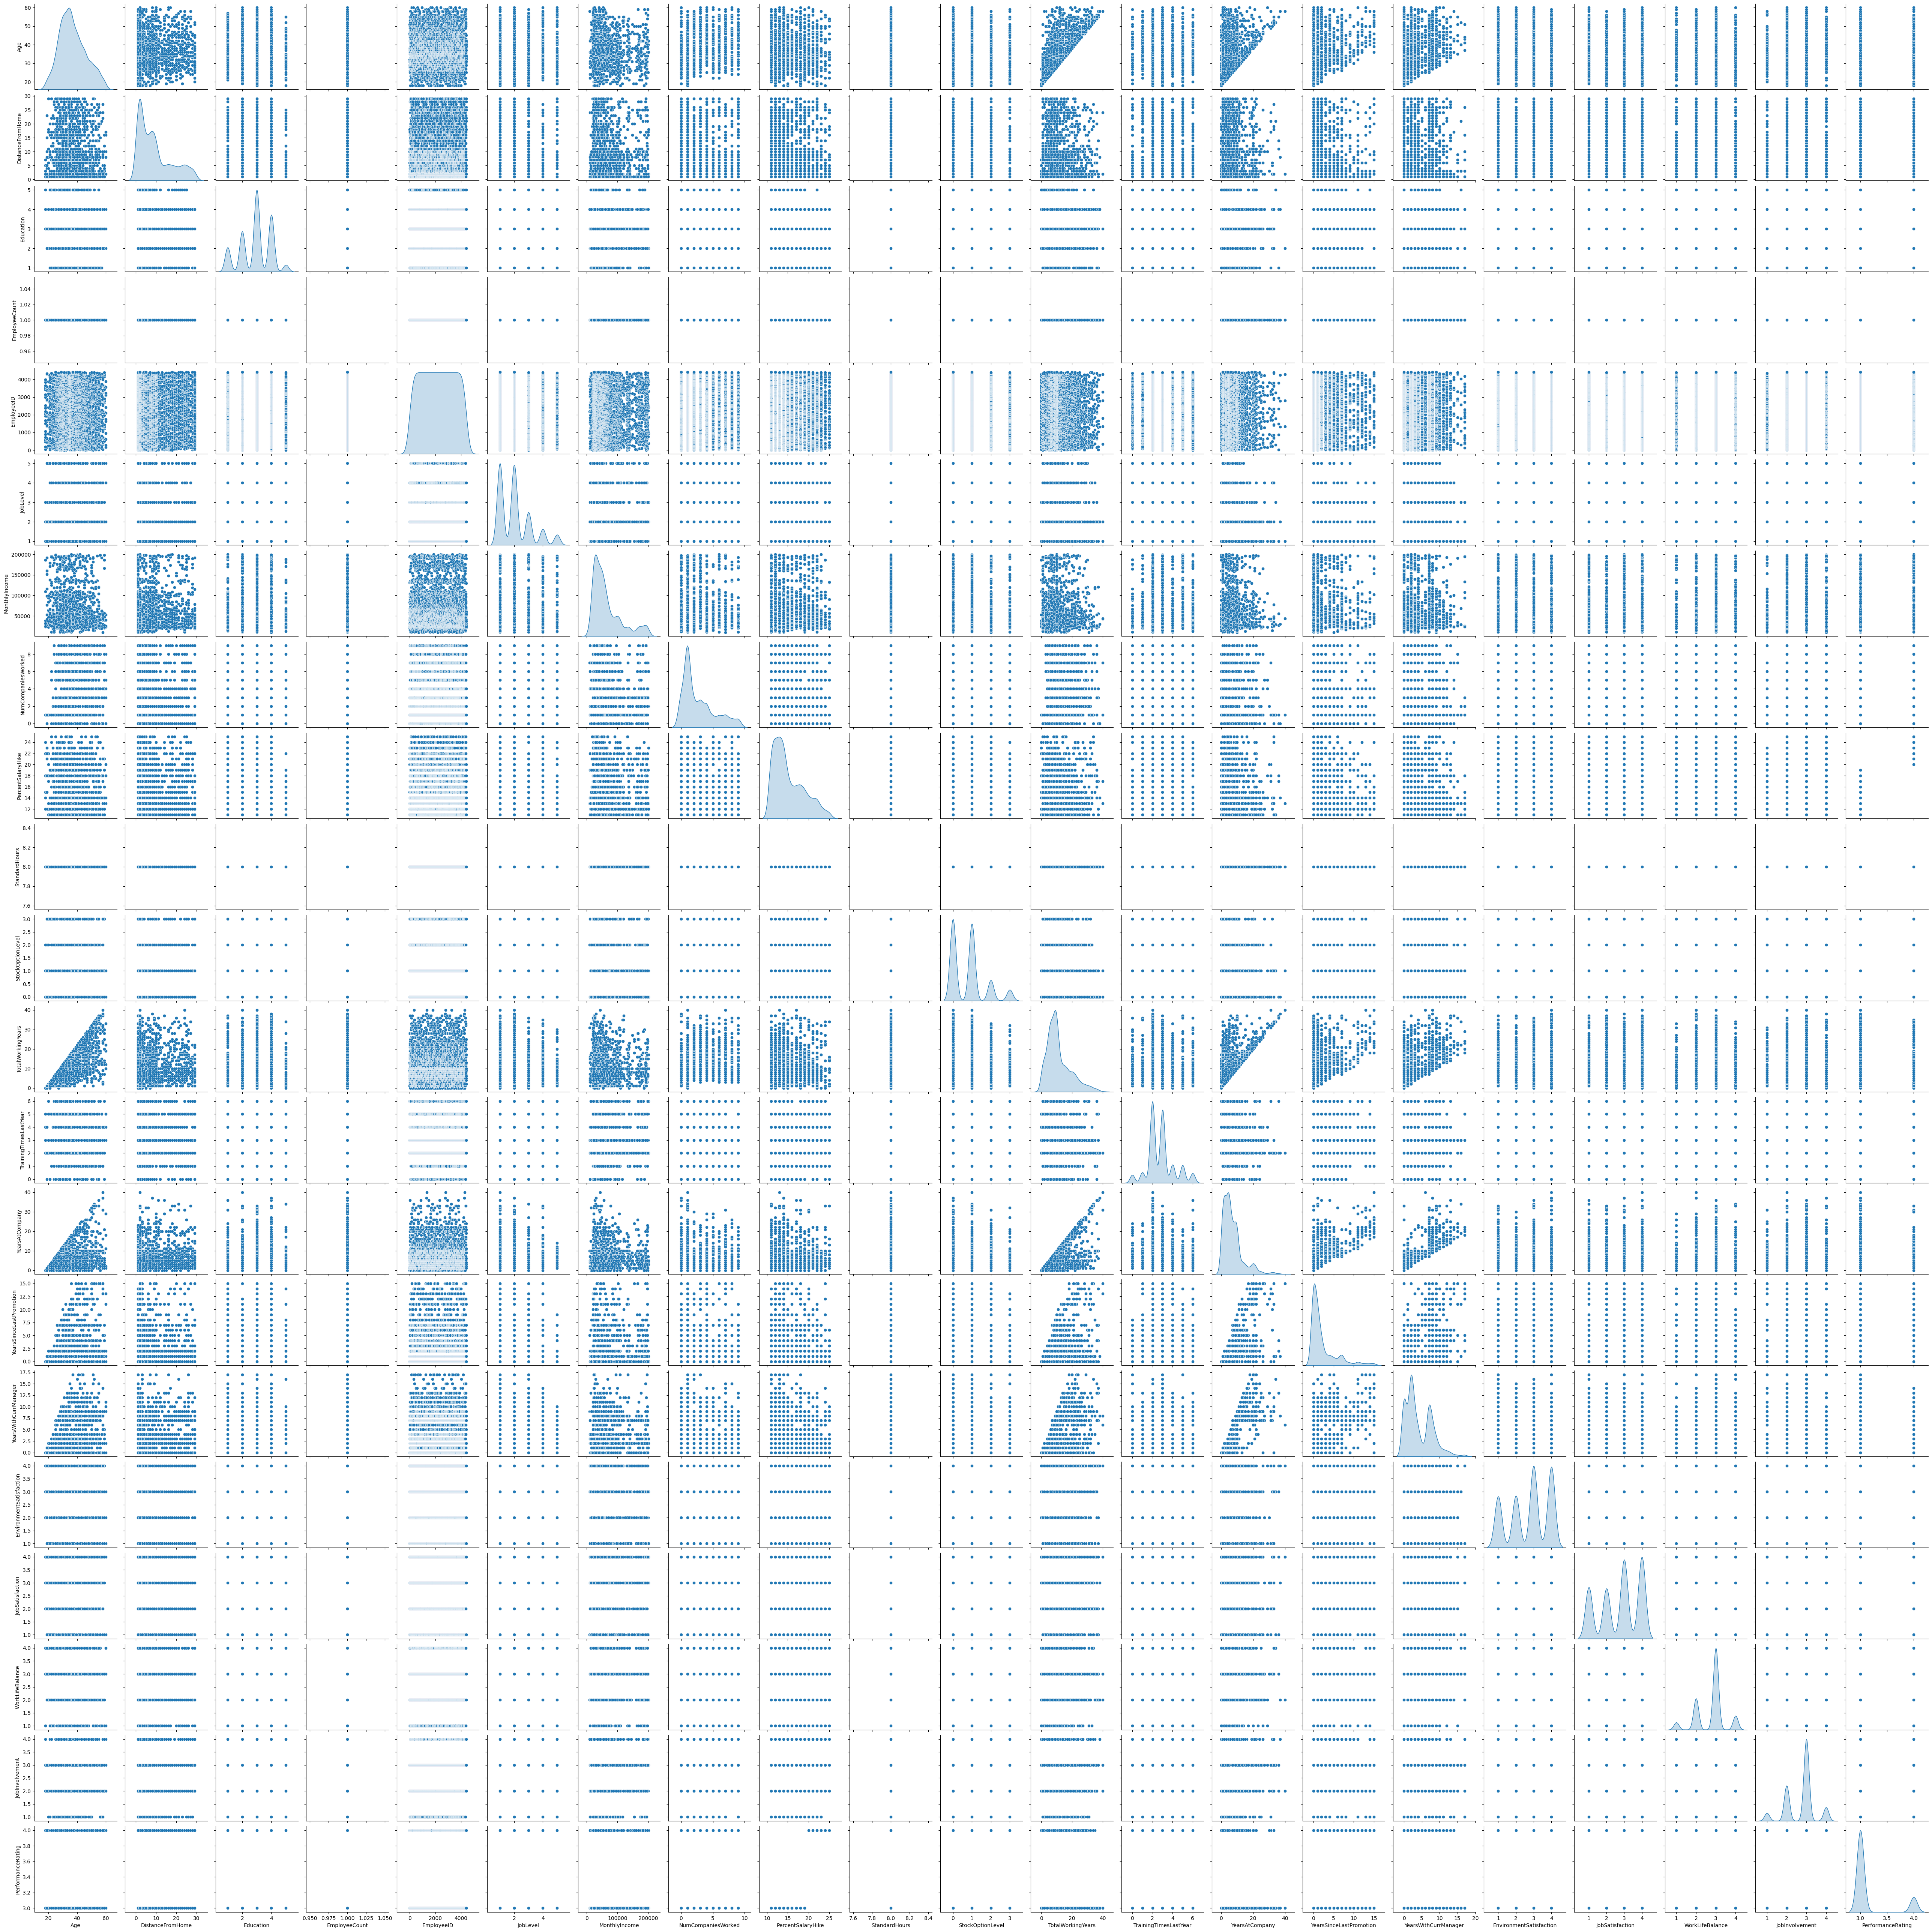

In [4]:
# Visualize missing data
msno.matrix(generalData)
plt.show()
sns.pairplot(generalData, diag_kind='kde')
plt.show()

# Remplacement des données manquantes

In [5]:
# Impute missing values
# For numerical columns, use median imputation
numerical_columns = generalData.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if col == "TotalWorkingYears":
        # Remplacer les NA dans 'TotalWorkingYears' par la valeur de 'YearsAtCompany'
        generalData[col] = generalData[col].fillna(generalData["YearsAtCompany"])
    else:
        # Remplacer les NA pour les autres colonnes numériques par leur médiane
        generalData[col] = generalData[col].fillna(generalData[col].median())
        
# For categorical columns, use mode imputation
categorical_columns = generalData.select_dtypes(include=['object']).columns
generalData[categorical_columns] = generalData[categorical_columns].fillna(generalData[categorical_columns].mode().iloc[0])

In [6]:
generalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

# Analyse Univariable

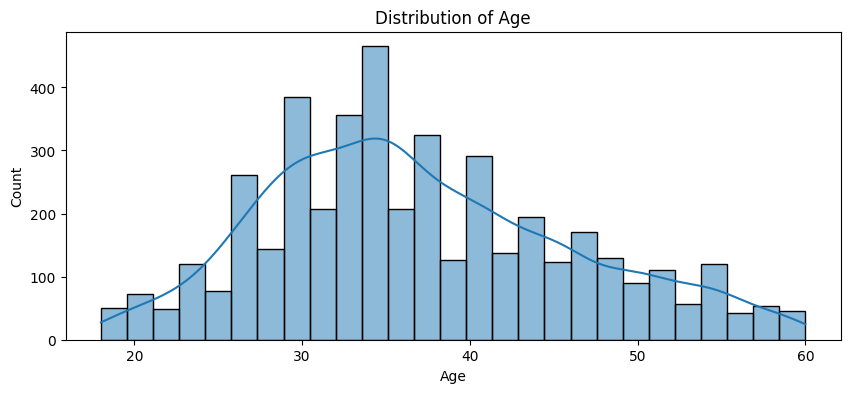

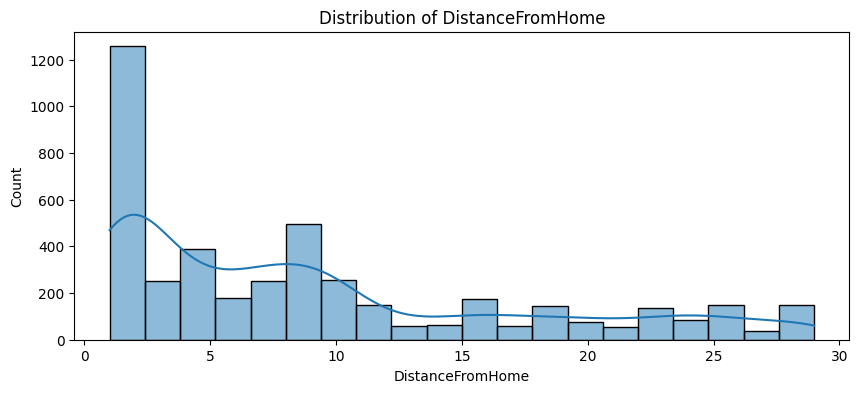

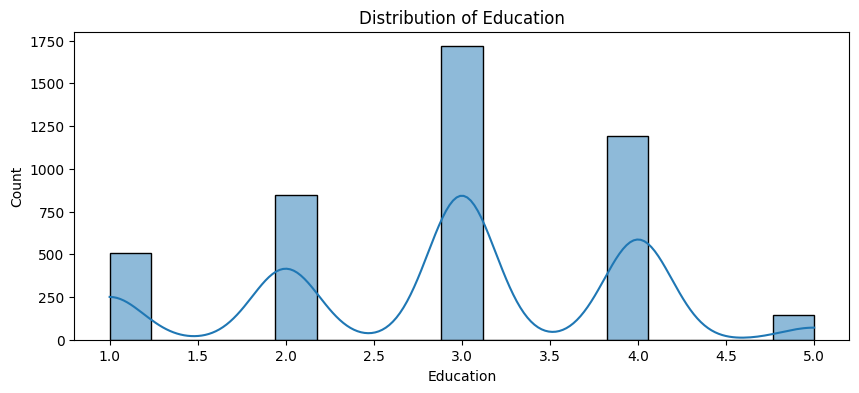

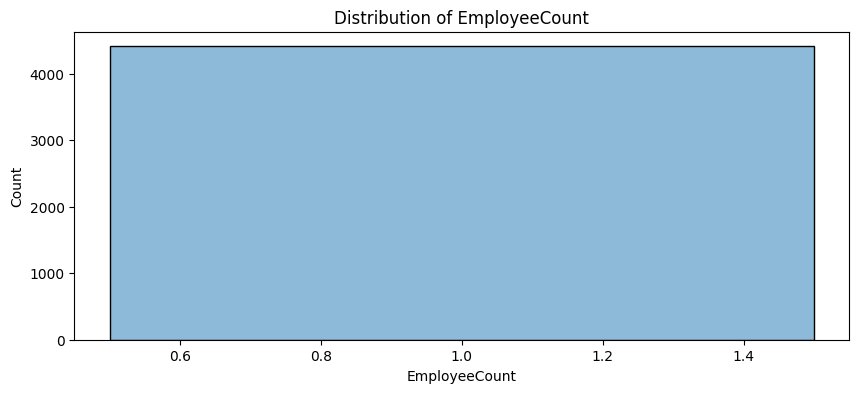

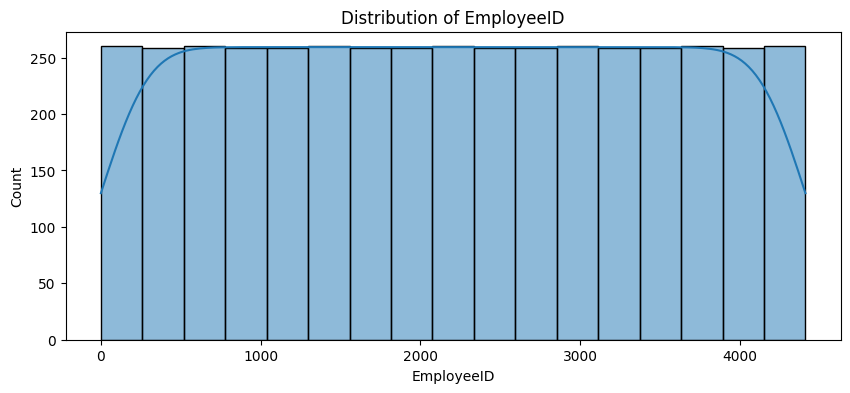

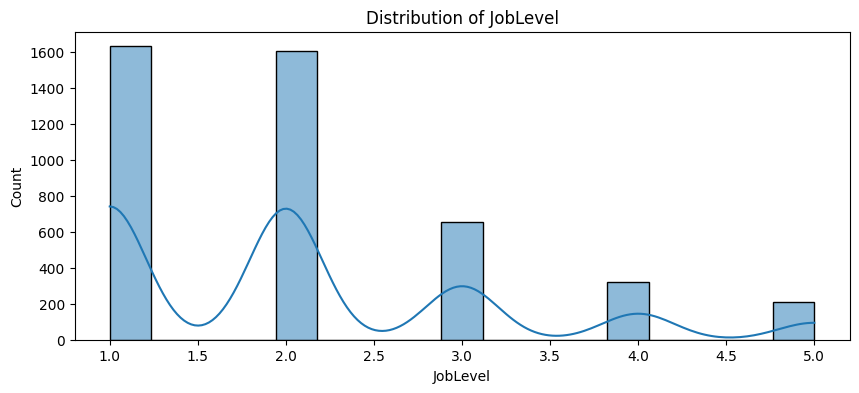

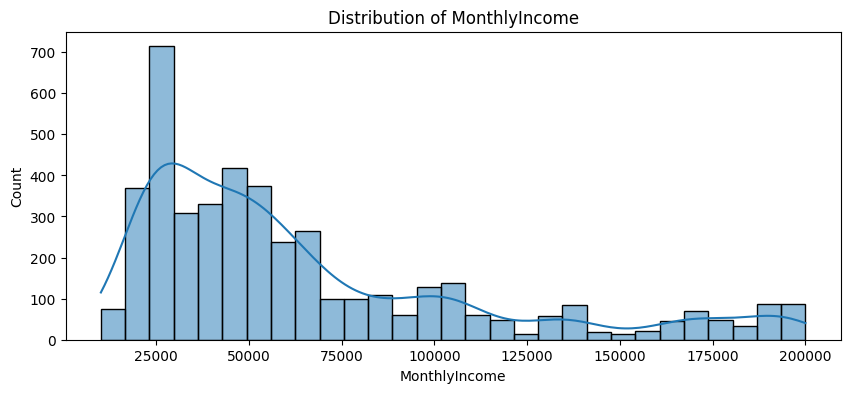

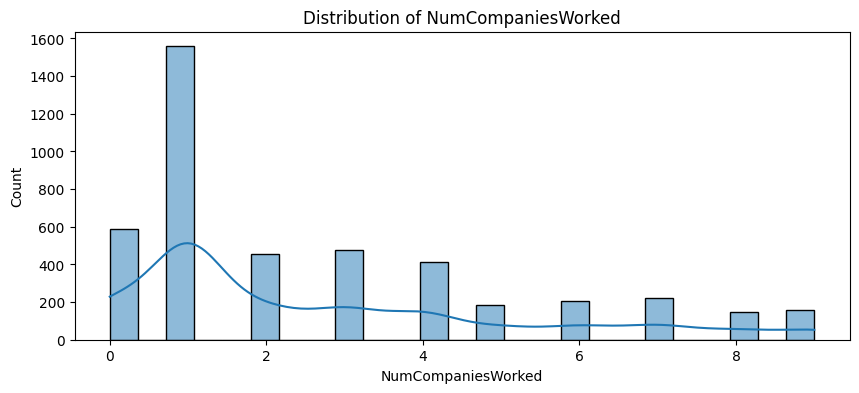

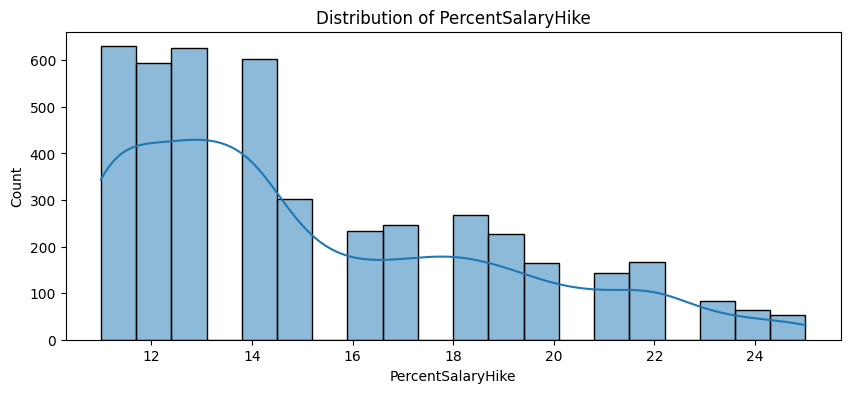

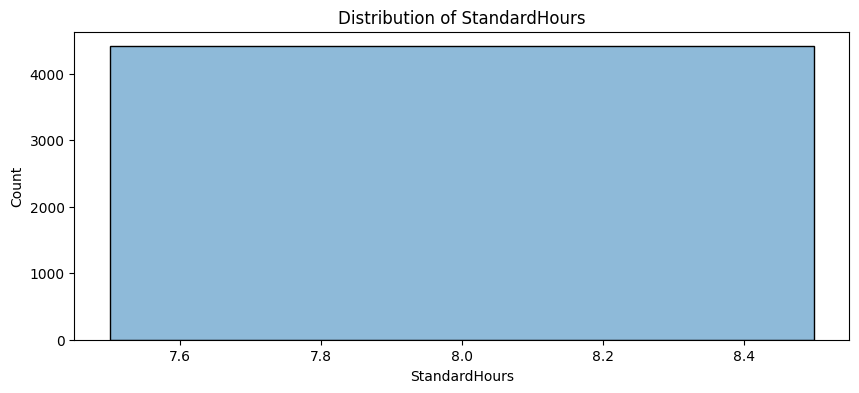

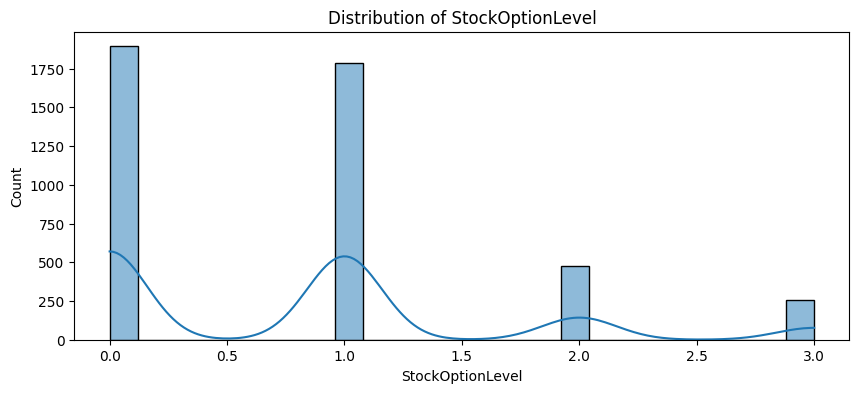

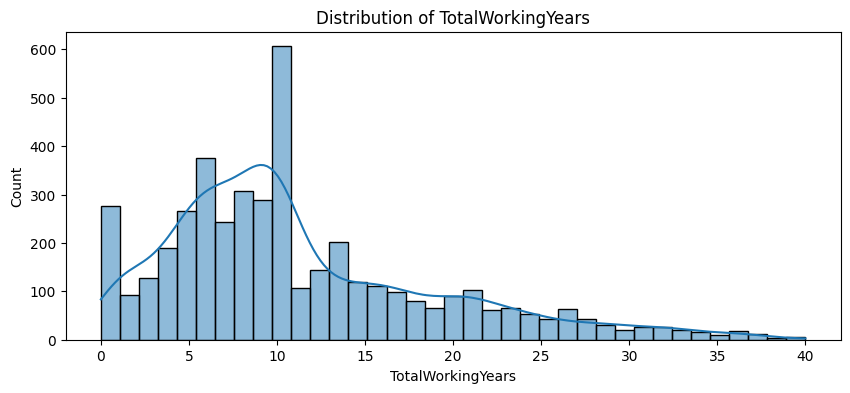

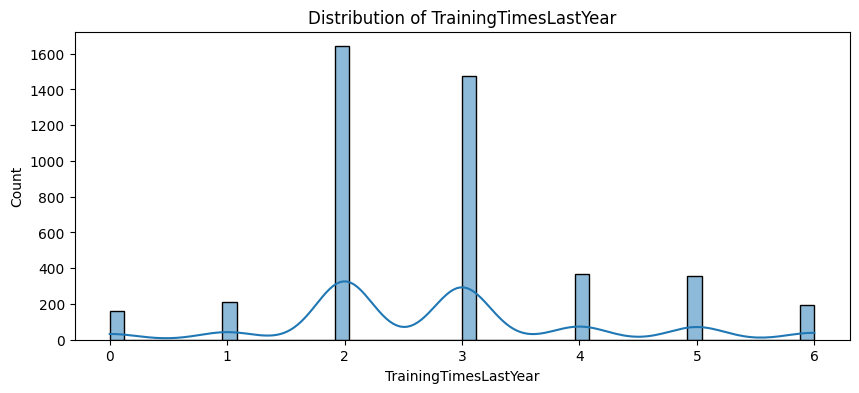

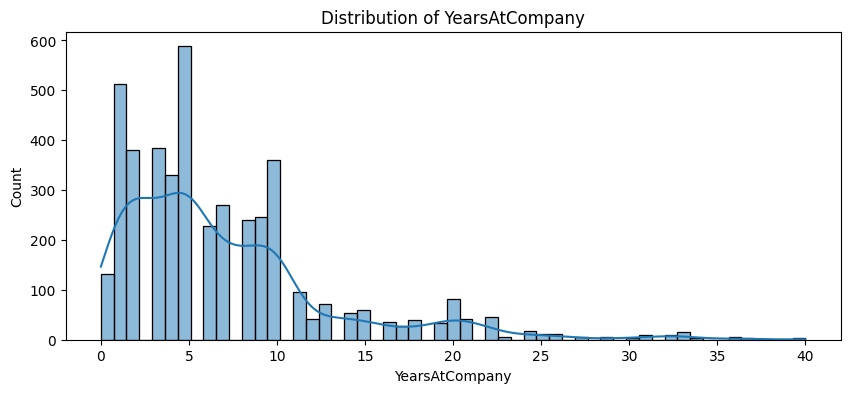

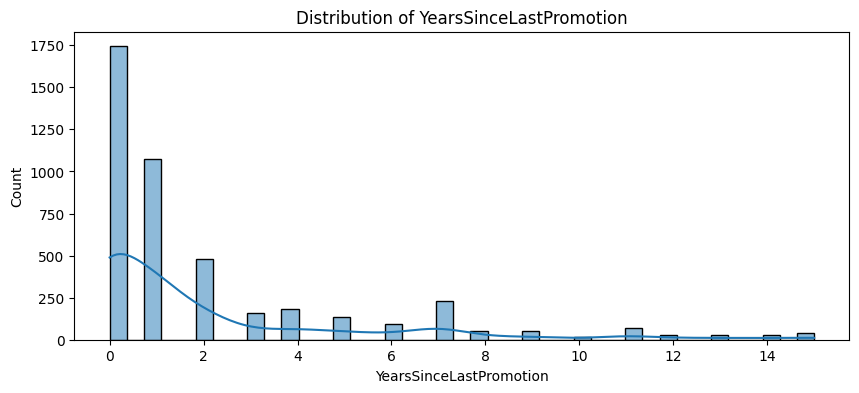

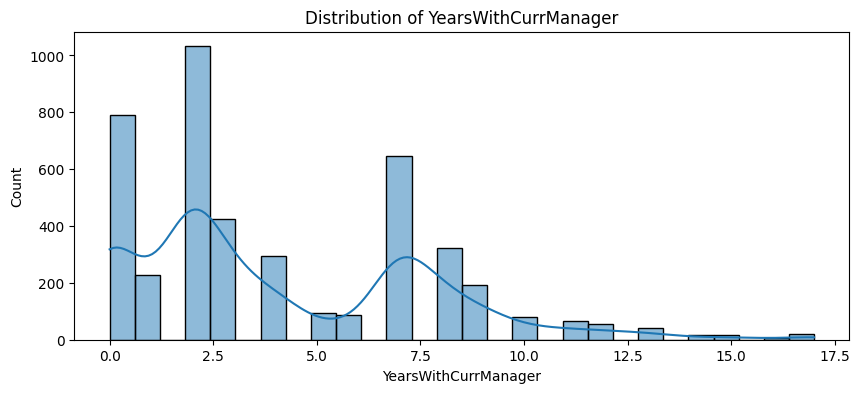

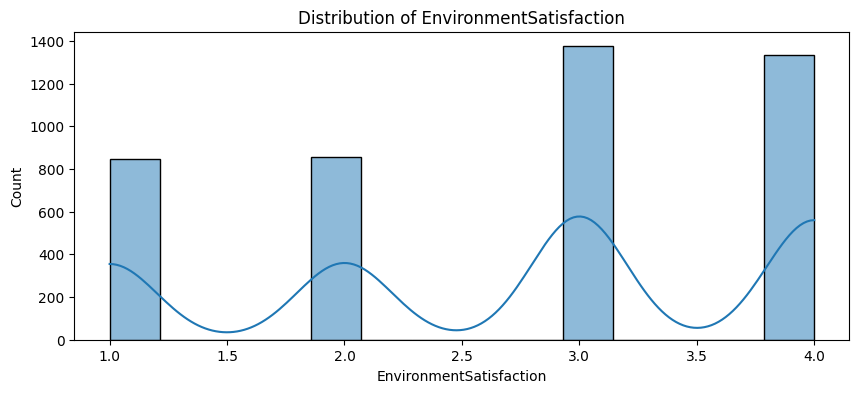

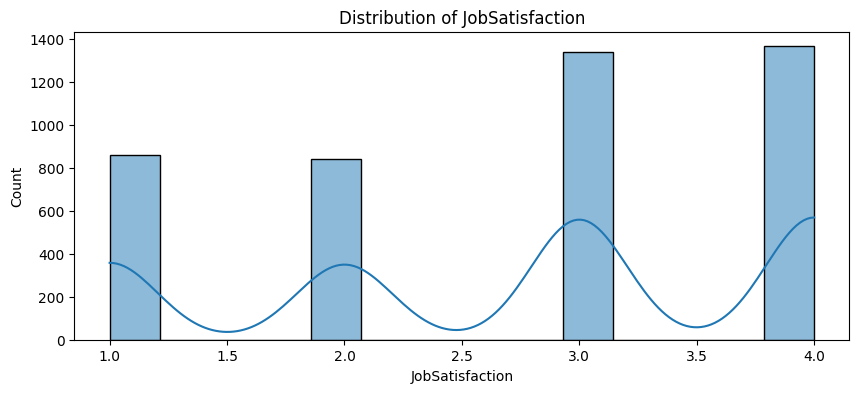

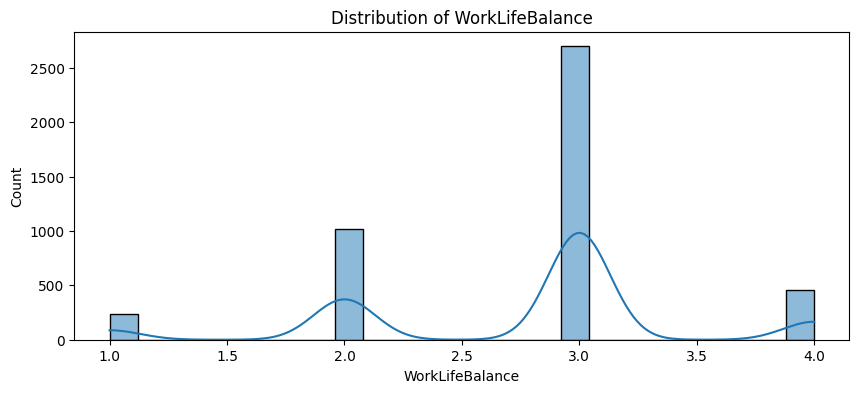

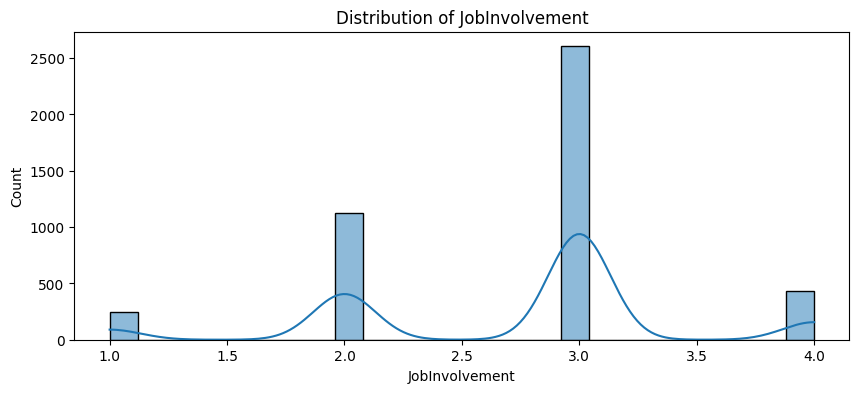

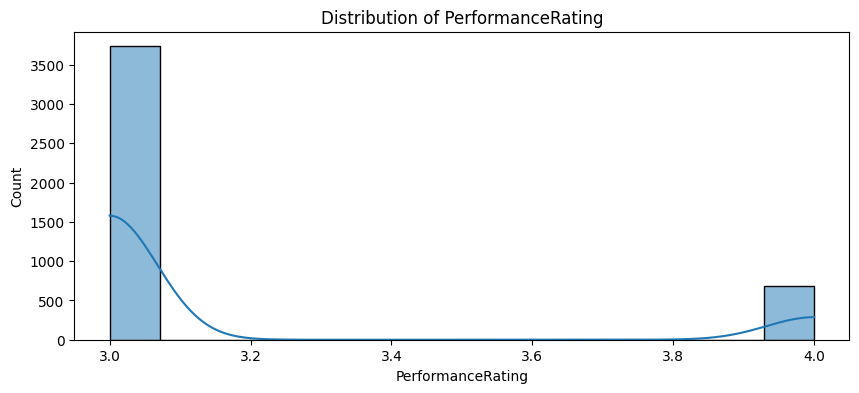

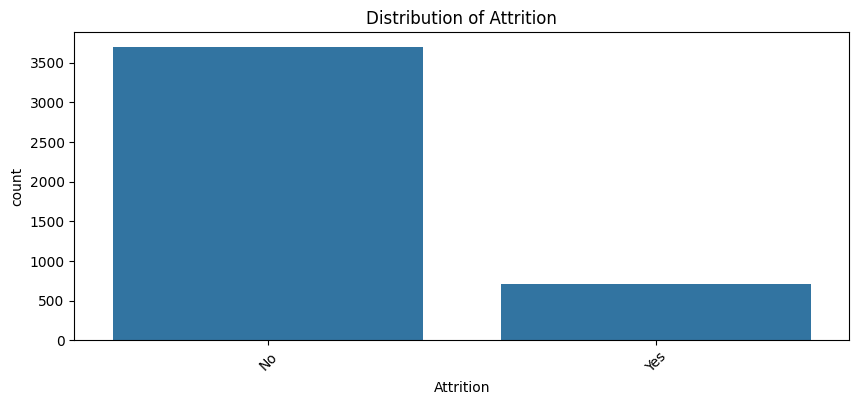

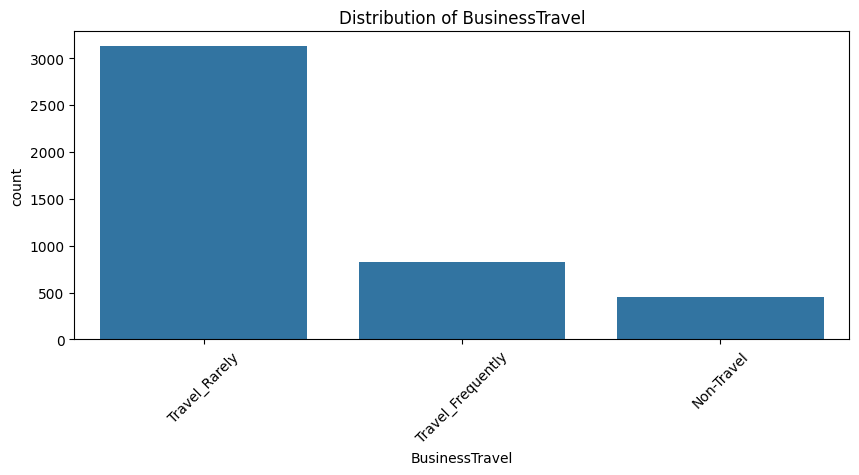

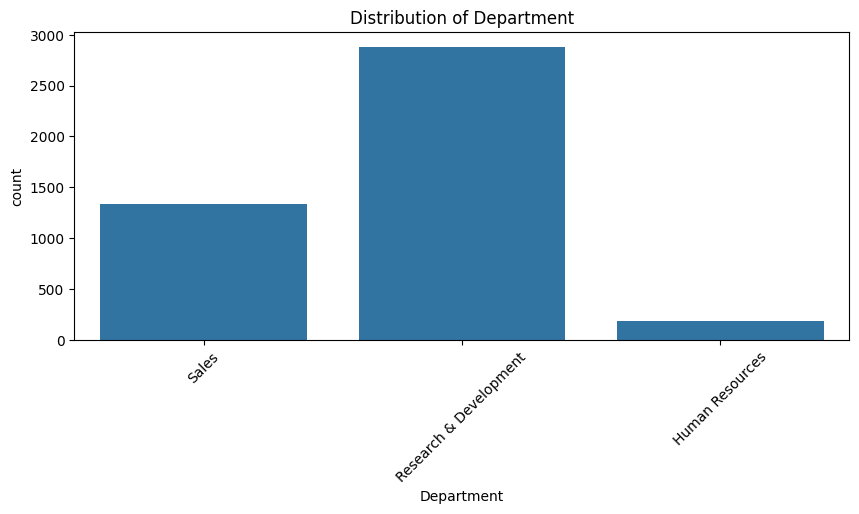

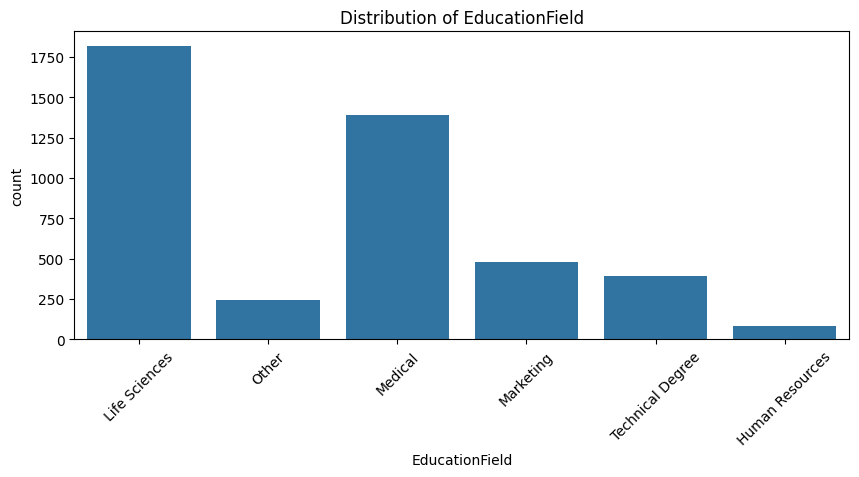

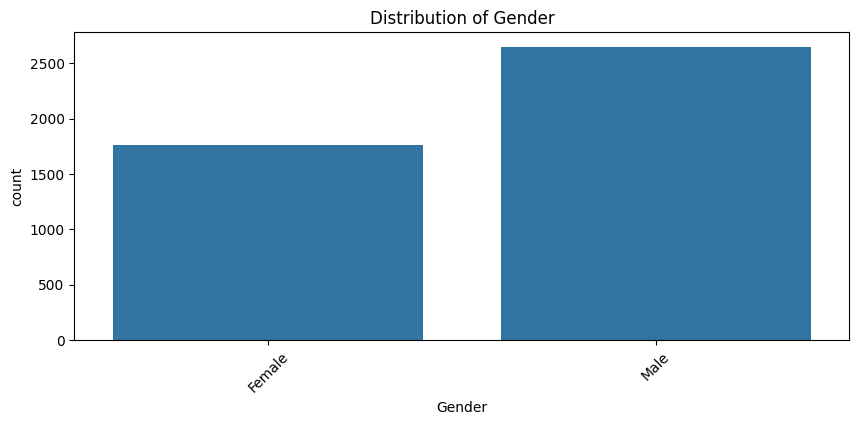

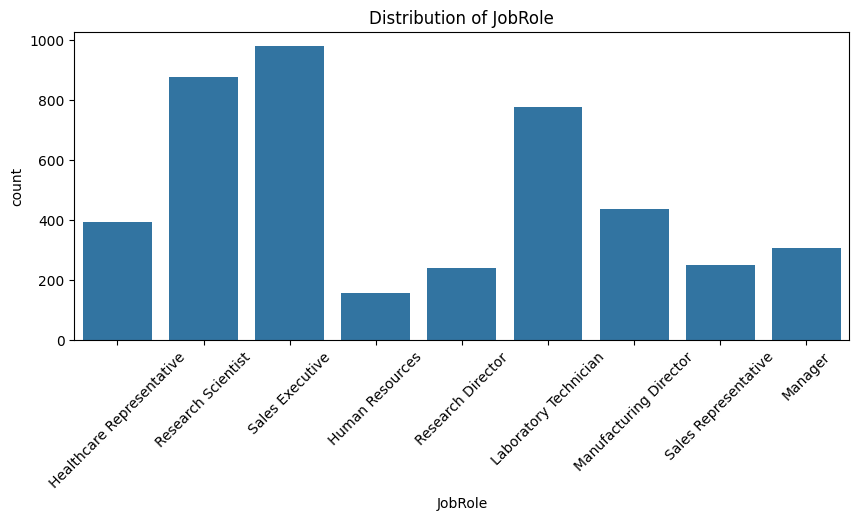

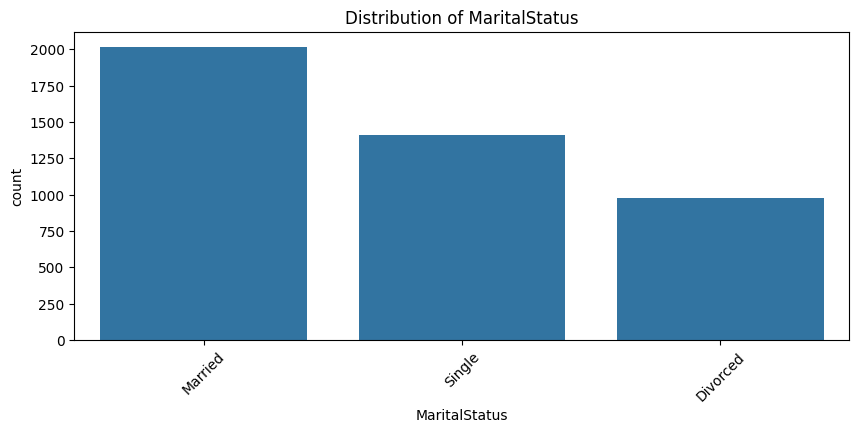

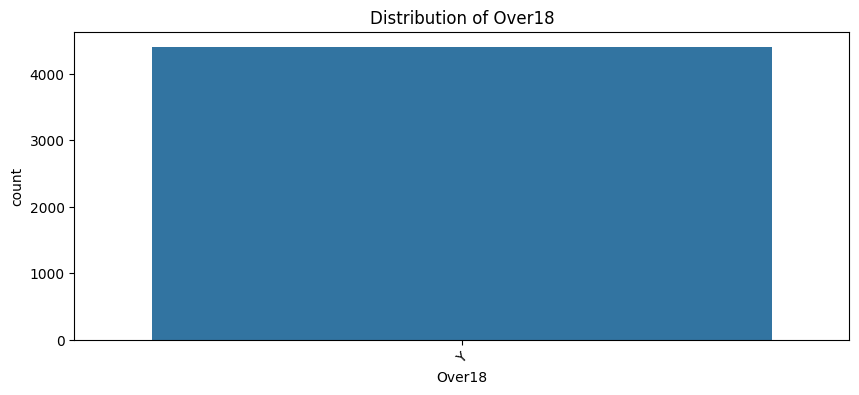

In [7]:
# Univariate analysis for numerical features
for column in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(generalData[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Univariate analysis for categorical features
for column in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=generalData[column])
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Fusion des CSV InTime et OutTime

In [8]:
# Charger les données
inTime.rename(columns={'Unnamed: 0':'EmployeeID'},inplace=True)
outTime.rename(columns={'Unnamed: 0':'EmployeeID'},inplace=True)
inTime.replace("NA",np.nan,inplace=True)

for col in inTime.columns.array[1::]:
    inTime[col] = pd.to_datetime(inTime[col],format='%Y-%m-%d %H:%M:%S')
for col in outTime.columns.array[1::]:
    outTime[col] = pd.to_datetime(outTime[col],format='%Y-%m-%d %H:%M:%S')
    inTime.dtypes
# refractor the time_diff inTime and outTime into a single dataframe with the following columns : employeeID, date, time_diff, entry_time, exit_time, exit_time - entry_time
# Melt the inTime and outTime dataframes to long format
inTime_melted = inTime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='Entry_Time')
outTime_melted = outTime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='Exit_Time')

# Merge the melted dataframes on EmployeeID and Date
merged_times = pd.merge(inTime_melted, outTime_melted, on=['EmployeeID', 'Date'])
merged_times.dropna(inplace=True)

# Calculate the time difference
merged_times['Worktime'] = merged_times['Exit_Time'] - merged_times['Entry_Time']

# Reorder columns
times_df = merged_times[['EmployeeID', 'Entry_Time', 'Exit_Time', 'Worktime']]
# Calculate the mean worktime and number of days worked per employee
worktime_df = times_df.groupby('EmployeeID').agg(MeanWorktime=('Worktime', 'mean'),DaysWorked=('Worktime', 'count')).reset_index()
worktime_df.describe()

EmployeeID               MeanWorktime   DaysWorked
count  4410.000000                       4410  4410.000000
mean   2205.500000  0 days 07:42:02.850424120   236.265306
std    1273.201673  0 days 01:20:24.784576008     5.503779
min       1.000000  0 days 05:57:01.814977973   225.000000
25%    1103.250000  0 days 06:40:23.999167221   232.000000
50%    2205.500000  0 days 07:24:24.337947974   236.000000
75%    3307.750000  0 days 08:22:07.329191312   241.000000
max    4410.000000  0 days 11:01:51.457264957   248.000000

# Fusion de tous les CSV

In [9]:
allDataSet = generalData.merge(worktime_df, on=['EmployeeID'], how='outer')

# Nettoyage des données en respectant l'éthique et la RGPD

In [10]:
cleanDataSet = allDataSet
cleanDataSet['Age'] = cleanDataSet['Age'].apply(lambda x: round(x / 5) * 5)
cleanDataSet['MeanWorktime'] = cleanDataSet['MeanWorktime'].apply(
    lambda x: (
    datetime.strptime(str(x).split(" ")[-1].split(".")[0], '%H:%M:%S')  # Analyse de l'heure et des secondes
    - timedelta(minutes=(datetime.strptime(str(x).split(" ")[-1].split(".")[0], '%H:%M:%S').minute % 15))  # Arrondir à la quinzaine
    ).strftime('%H:%M')
)
cleanDataSet['DaysWorked'] = cleanDataSet['DaysWorked'].apply(lambda x: round(x / 5) * 5)
cleanDataSet['Meritocracy'] = cleanDataSet['PerformanceRating'] / cleanDataSet['PercentSalaryHike']

In [11]:
cleanDataSet.head()

Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   50        No      Travel_Rarely                   Sales                 6   
1   30       Yes  Travel_Frequently  Research & Development                10   
2   30        No  Travel_Frequently  Research & Development                17   
3   40        No         Non-Travel  Research & Development                 2   
4   30        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   YearsAtCompany YearsSinceLastPromotion YearsWithCurrManager  \
0               1                       0                    0   
1               5                       1                    4   
2               5                       0                    3   
3               8                       7                    5   
4               6                       0                    4   

   EnvironmentSatisfaction  JobSatisfaction WorkLifeBalance  JobInvolvement  \
0                      3.0              4.0             2.0               3   
1                      3.0              2.0             4.0               2   
2                      2.0              2.0             1.0               3   
3                      4.0              4.0             3.0               2   
4                      4.0              1.0             3.0               3   

   PerformanceRating  MeanWorktime  DaysWorked  
0                  3         07:15         230  
1                  4         07:30         235  
2                  3         07:00         240  
3                  3         07:00         235  
4                  3         08:00         245  

[5 rows x 31 columns]

# Analyse Bivariée

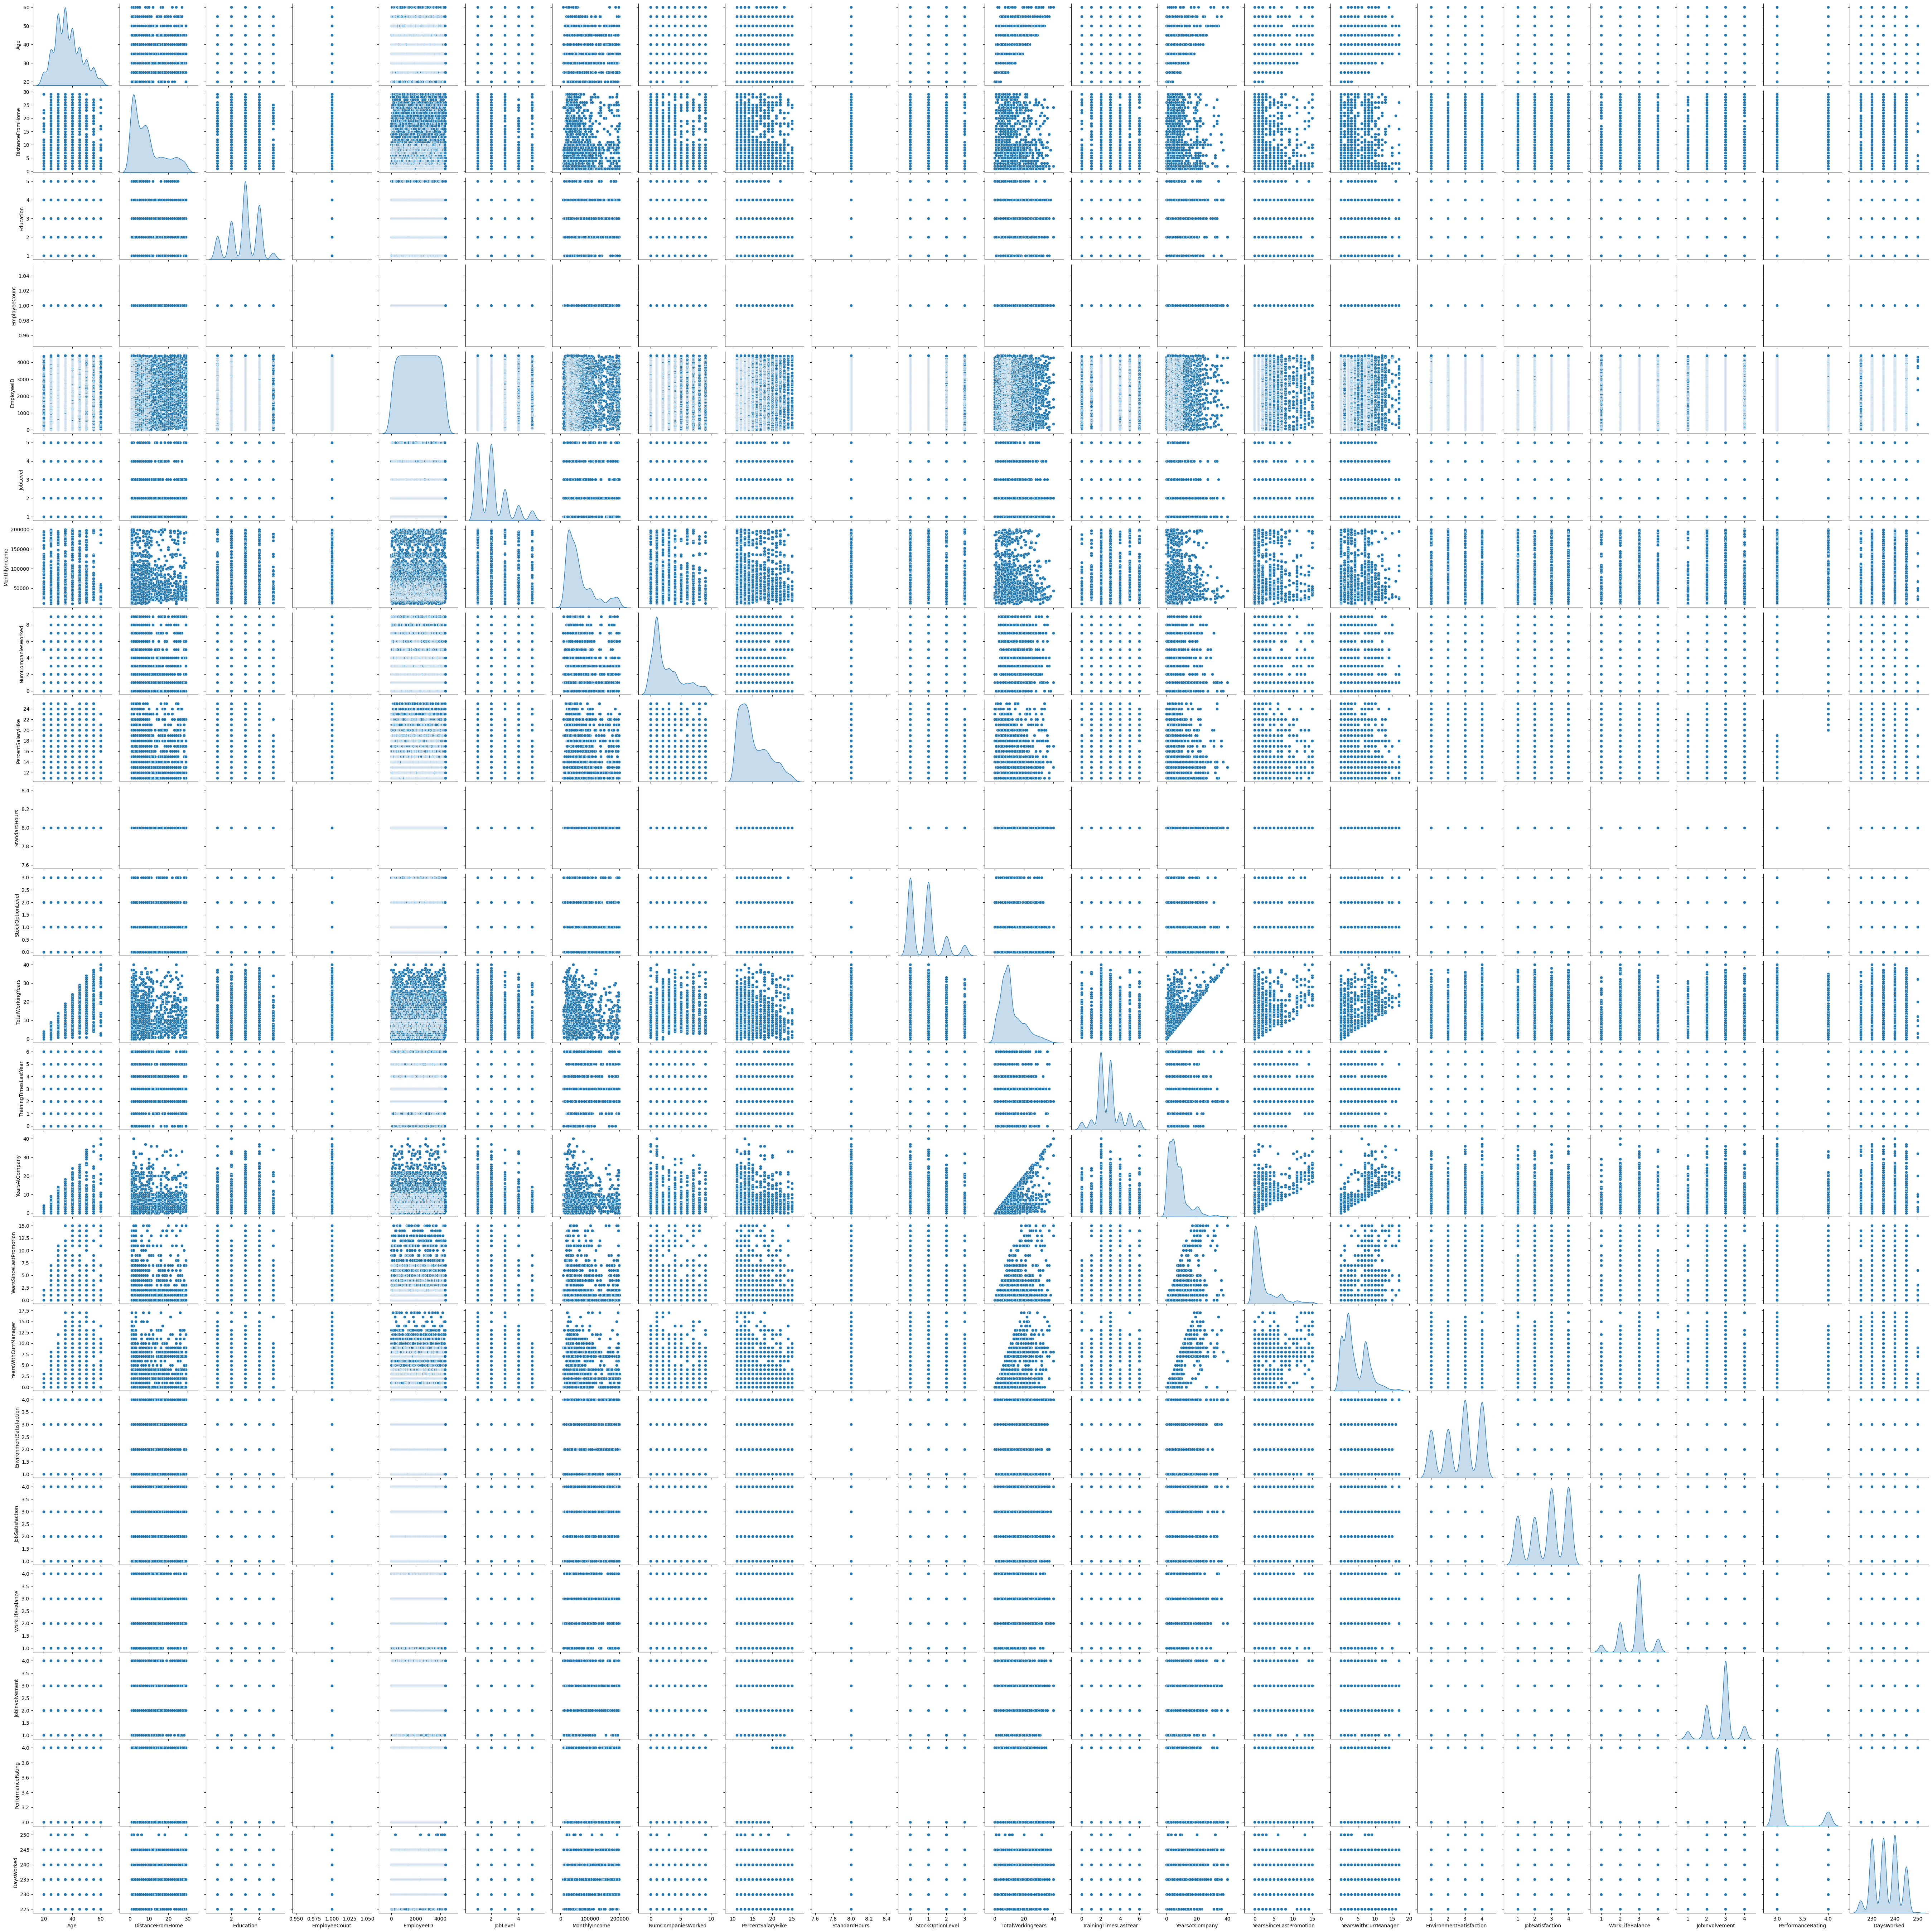

In [12]:
sns.pairplot(cleanDataSet, diag_kind='kde')
plt.show()

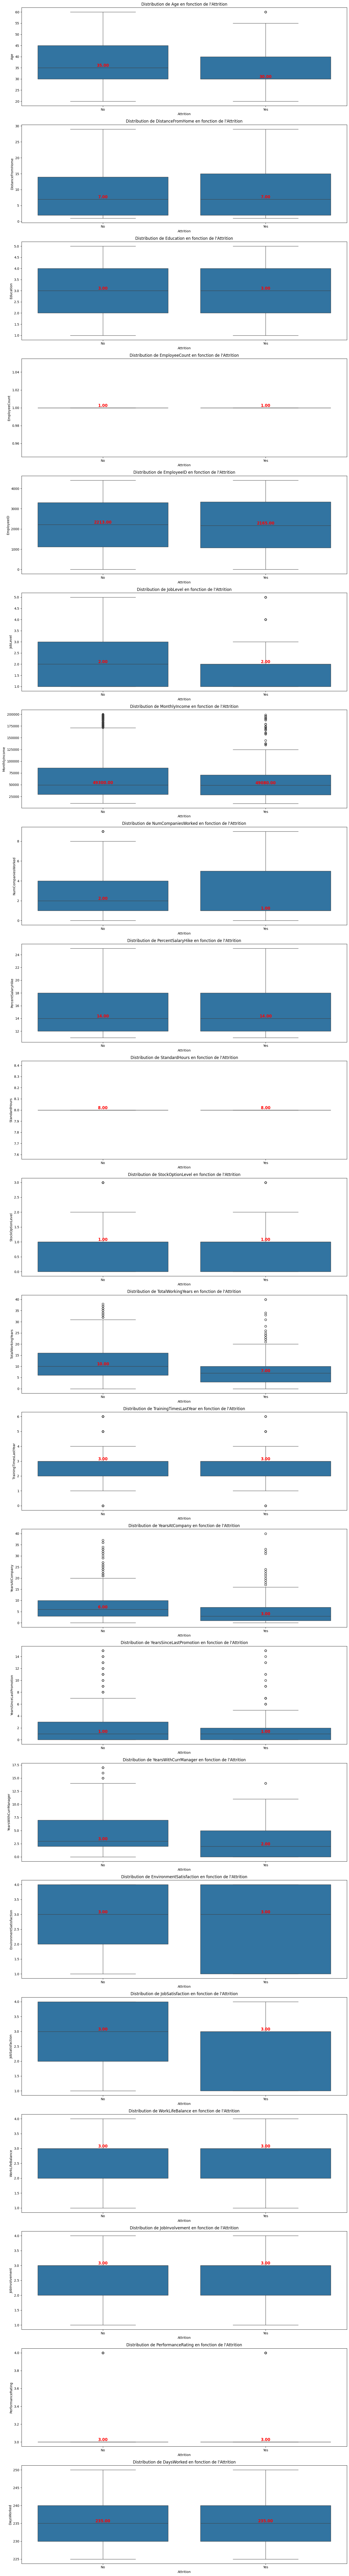

In [14]:
# Sélectionner uniquement les colonnes numériques
numerical_columns = cleanDataSet.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numerical_columns) * 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(x='Attrition', y=col, data=cleanDataSet)
    
    # Ajouter les médianes pour comparer l'écart entre Oui/Non
    median_values = cleanDataSet.groupby("Attrition")[col].median()
    for j, attrition_value in enumerate(median_values.index):
        plt.text(j, median_values[attrition_value], f"{median_values[attrition_value]:.2f}", 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')

    plt.title(f"Distribution de {col} en fonction de l'Attrition")

plt.tight_layout()
plt.show()


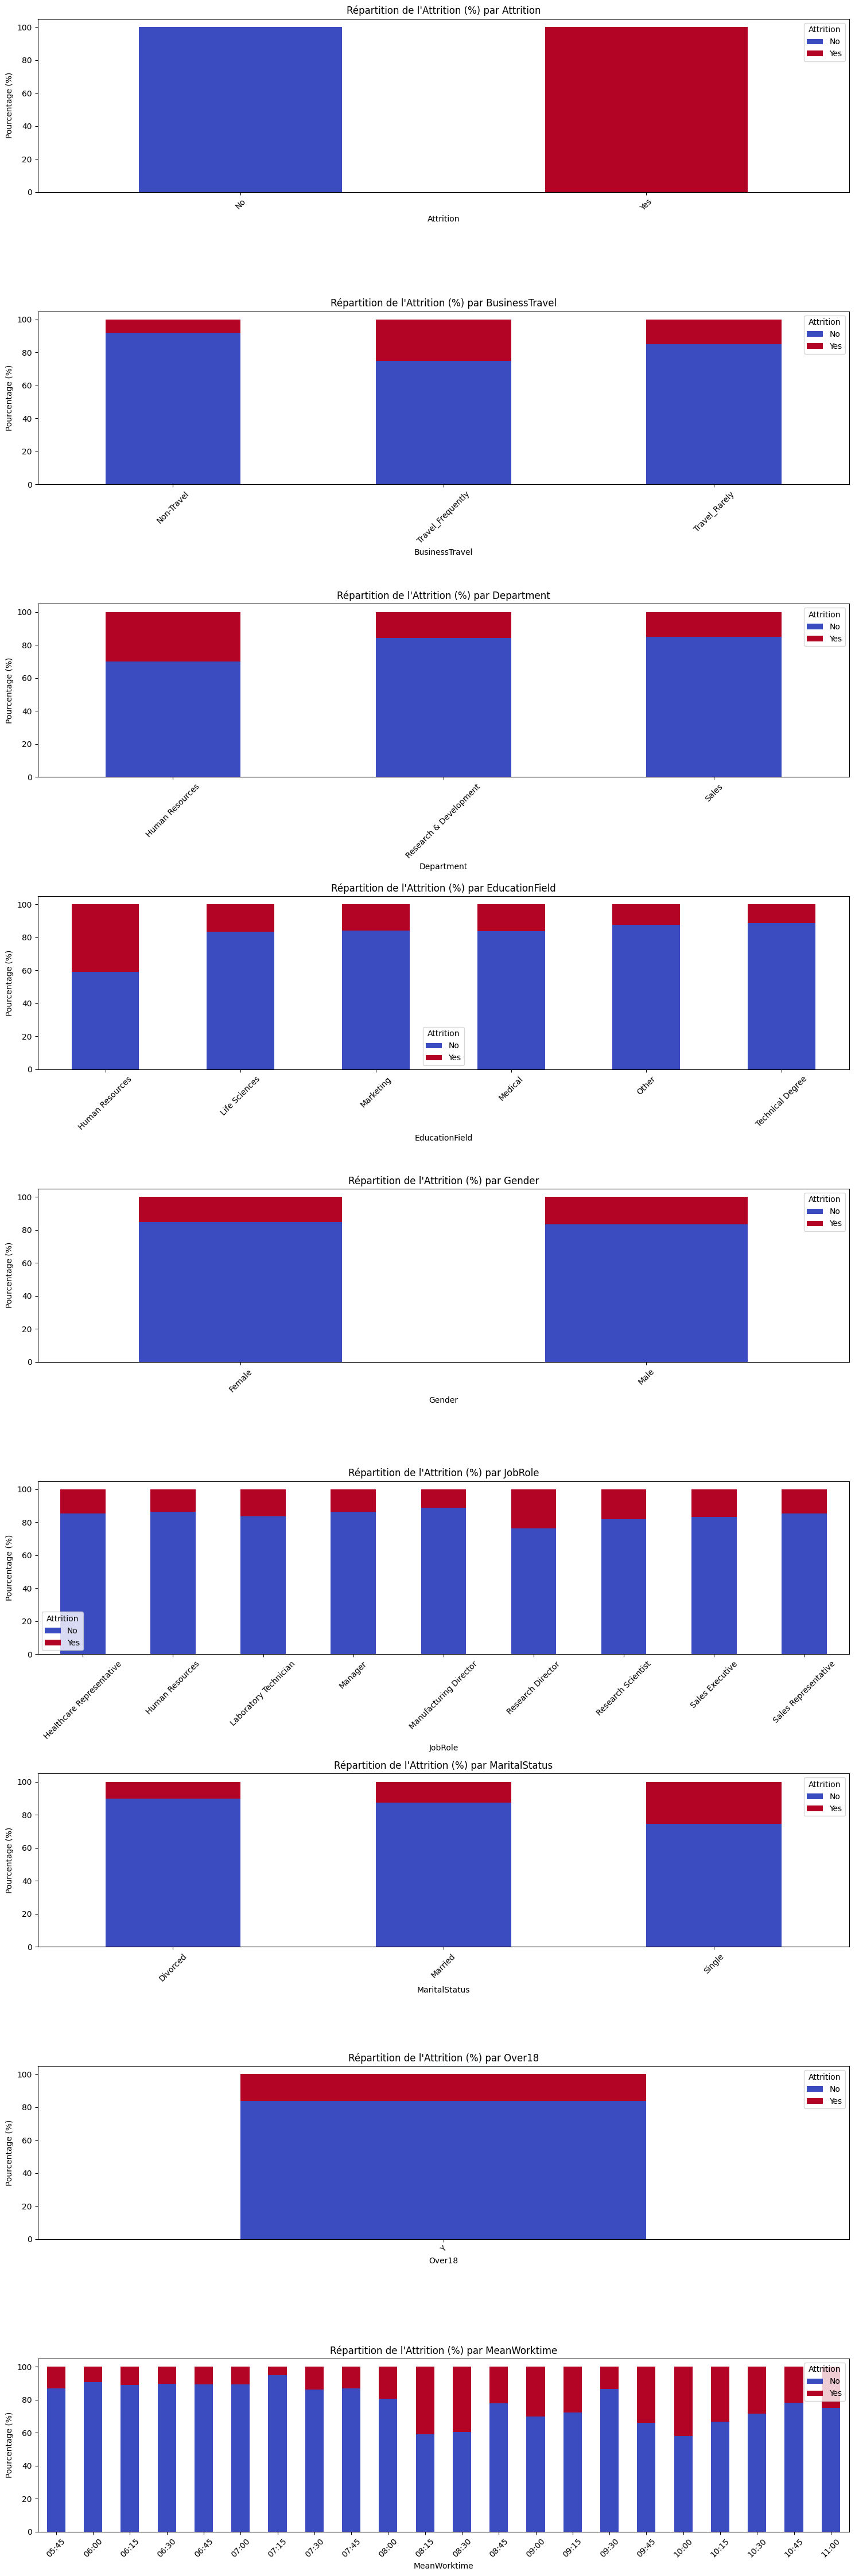

In [15]:
categorical_columns = cleanDataSet.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, len(categorical_columns) * 5))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    
    # Calcul du pourcentage d'attrition par catégorie
    category_percent = pd.crosstab(cleanDataSet[col], cleanDataSet['Attrition'], normalize='index') * 100
    
    # Création du barplot empilé
    category_percent.plot(kind='bar', stacked=True, ax=plt.gca(), colormap="coolwarm")
    
    plt.ylabel("Pourcentage (%)")
    plt.title(f"Répartition de l'Attrition (%) par {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [20]:
cleanDataSet = cleanDataSet.drop(columns=['EmployeeID', 'Gender', 'Over18','PerformanceRating', 'PercentSalaryHike'])
exportDataCSV(cleanDataSet)

KeyError: "['EmployeeID', 'Gender', 'Over18'] not found in axis"

In [17]:
cleanDataSet.describe()
sns.pairplot(cleanDataSet, diag_kind='kde')
plt.show()

Age  DistanceFromHome    Education  EmployeeCount     JobLevel  \
count  4410.000000       4410.000000  4410.000000         4410.0  4410.000000   
mean     36.935374          9.192517     2.912925            1.0     2.063946   
std       9.270959          8.105026     1.023933            0.0     1.106689   
min      20.000000          1.000000     1.000000            1.0     1.000000   
25%      30.000000          2.000000     2.000000            1.0     1.000000   
50%      35.000000          7.000000     3.000000            1.0     2.000000   
75%      45.000000         14.000000     4.000000            1.0     3.000000   
max      60.000000         29.000000     5.000000            1.0     5.000000   

       MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  StandardHours  \
count    4410.000000         4410.000000        4410.000000         4410.0   
mean    65029.312925            2.691837          15.209524            8.0   
std     47068.888559            2.493912           3.659108            0.0   
min     10090.000000            0.000000          11.000000            8.0   
25%     29110.000000            1.000000          12.000000            8.0   
50%     49190.000000            2.000000          14.000000            8.0   
75%     83800.000000            4.000000          18.000000            8.0   
max    199990.000000            9.000000          25.000000            8.0   

       StockOptionLevel  ...  YearsWithCurrManager  EnvironmentSatisfaction  \
count       4410.000000  ...           4410.000000              4410.000000   
mean           0.793878  ...              4.123129                 2.725170   
std            0.851883  ...              3.567327                 1.089852   
min            0.000000  ...              0.000000                 1.000000   
25%            0.000000  ...              2.000000                 2.000000   
50%            1.000000  ...              3.000000                 3.000000   
75%            1.000000  ...              7.000000                 4.000000   
max            3.000000  ...             17.000000                 4.000000   

       JobSatisfaction  WorkLifeBalance  JobInvolvement  PerformanceRating  \
count      4410.000000      4410.000000     4410.000000        4410.000000   
mean          2.729478         2.763492        2.729932           3.153741   
std           1.098904         0.703541        0.711400           0.360742   
min           1.000000         1.000000        1.000000           3.000000   
25%           2.000000         2.000000        2.000000           3.000000   
50%           3.000000         3.000000        3.000000           3.000000   
75%           4.000000         3.000000        3.000000           3.000000   
max           4.000000         4.000000        4.000000           4.000000   

        DaysWorked  Meritocracy   Commitment  Recognition  
count  4410.000000  4410.000000  4377.000000  4278.000000  
mean    236.277778     0.214815     0.683609     0.299187  
std       5.707482     0.036024     0.324062     0.341759  
min     225.000000     0.157895     0.000000     0.000000  
25%     230.000000     0.181818     0.423077     0.000000  
50%     235.000000     0.214286     0.800000     0.174242  
75%     240.000000     0.250000     1.000000     0.500000  
max     250.000000     0.272727     1.000000     1.000000  

[8 rows x 24 columns]